In [88]:
import agents
import game
import mechanisms

In [89]:
import importlib
importlib.reload(agents)
importlib.reload(game)
importlib.reload(mechanisms)

<module 'mechanisms' from '/Users/davidzhu/Classes/CS281/Finding_Friends/mechanisms.py'>

In [90]:
%matplotlib inline
import numpy as np
import pandas as pd

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [91]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
memory = ReplayMemory(10000)

In [92]:
class DQ_Learner(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQ_Learner, self).__init__()
        self.head = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.head(x)

class DQ_Agent(agents.Agent):
    def __init__(self, id, level, input_dim, output_dim):
        super(DQ_Agent, self).__init__(id, level)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.learner = DQ_Learner(input_dim, output_dim).to(device)
        self.steps = 0
        
    def pick_friends(self, levels, cap, skill_levels=None):
        state = [cap] + levels
        if skill_levels is not None:
            state = state + skill_levels
        
        state = torch.tensor(state, device=device, dtype=torch.float)
#         print(state)
        
        if self.last_reward is not None:
            memory.push(self.last_state, self.last_action, state, self.last_reward)
        
        # Perform one step of the optimization (on the target network)
        optimize_model()
        
        # Perform e-greedy policy 
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps / EPS_DECAY)
        self.steps += 1
        if sample > eps_threshold:
#             print('Policy')
            with torch.no_grad():
#                 temp = self.learner(state)
#                 print(temp)
#                 print(temp.max(0))
#                 print(temp.max(0)[1])
#                 print(temp.max(0)[1].view(1, 1))
                action = self.learner(state).max(0)[1].view(1, 1)
        else:
            action = torch.tensor([[np.random.randint(0, len(levels) - 1)]], device=device, dtype=torch.long)
#         probs = self.learner(state)
#         candidates = list(zip([i for i in range(len(levels))], probs))
#         candidates = sorted(candidates, key=lambda t: t[1])
        
#         action = candidates[0][0]
    
#         print(action)
    
        self.last_action = action
        self.last_state = state
        
        return action
    
    def accept_reward(self, reward, done):
        self.last_reward = torch.tensor([reward], device=device)
        if done:
            memory.push(self.last_state, self.last_action, None, self.last_reward)
            
            # Perform one step of the optimization (on the target network)
            optimize_model()
            

In [93]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

NUM_PLAYERS = 5
BASE_LVL = 0
LVL_CAP = 100
WIN_PROB = 0.4

AVG_INT = 100

REWARD_TYPE = "WINNERTAKEALL" # options: WINNERTAKEALL, PROPORTIONAL, RANKED

ff_mech = mechanisms.Baseline_Mechanism(num_players=NUM_PLAYERS, p=WIN_PROB)

input_dim = ff_mech.input_dim()
output_dim = ff_mech.output_dim()

policy_agent = DQ_Agent(NUM_PLAYERS - 1, BASE_LVL, input_dim, output_dim)
target_agent = DQ_Agent(NUM_PLAYERS - 1, BASE_LVL, input_dim, output_dim)

policy_net = policy_agent.learner
target_net = target_agent.learner
# policy_net = DQ_Learner(input_dim, output_dim).to(device)
# target_net = DQ_Learner(input_dim, output_dim).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())

steps_done = 0

# Don't need this because using the agent instead
# def select_action(state):
#     global steps_done
#     sample = random.random()
#     eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
#     steps_done += 1
#     if sample > eps_threshold:
#         with torch.no_grad():
#             return policy_net(state).max(1)[1].view(1, 1)
#     else:
#         return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_scores = []

def plot_scores():
    plt.figure(2)
    plt.clf()
    scores_t = torch.tensor(episode_scores, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(scores_t.numpy())
    # Take AVG_INT episode averages and plot them too
    if len(scores_t) >= AVG_INT:
        means = scores_t.unfold(0, AVG_INT, 1).mean(1).view(-1)
#         means = torch.cat((torch.zeros(99), means))
        plt.plot(np.arange(AVG_INT, AVG_INT + len(means)), means.numpy())
    
#     plt.pause(1)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [94]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])
    
    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
#     print(f'State Batch: {state_batch}')
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    
#     print(f'Actions: {policy_net(state_batch)}')
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
#     print(f'State Action Values: {state_action_values}')
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
#     print(f'Next State Values: {next_state_values}')
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

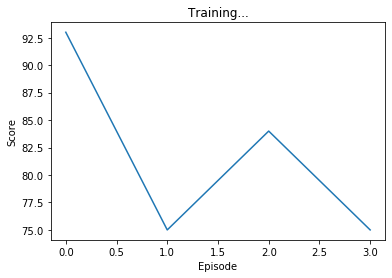

KeyboardInterrupt: 

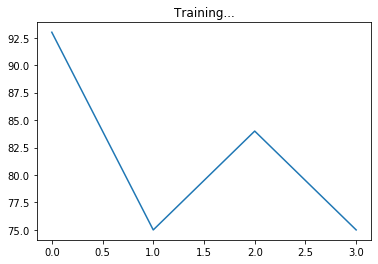

In [95]:
num_episodes = 300

ff_agents = [agents.Basic_Agent(i, BASE_LVL) for i in range(NUM_PLAYERS - 1)]
# ff_agents.append(agents.Lowest_Level_Agent(NUM_PLAYERS - 3, BASE_LVL))
# ff_agents.append(agents_Lowest_Level_Agent(NUM_PLAYERS - 2, BASE_LVL))
ff_agents.append(policy_agent)

ff_game = game.Game(players=ff_agents, mechanism=ff_mech, cap=LVL_CAP, reward_type=REWARD_TYPE, logging_level='DEBUG')

for i_episode in range(num_episodes):
    ff_game.play()
    episode_scores.append(ff_game.levels[policy_agent.id])
    plot_scores()
    ff_game.reset()
    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
print('Complete')
plt.ioff()
plt.show()

In [ ]:
sum(np.array(episode_scores) == LVL_CAP) / len(episode_scores)

In [ ]:
state = [100., 99., 0., 0., 0., 98.]
target_net(torch.tensor(state))